In [ ]:
!pip install datasets transformers torch pandas matplotlib seaborn scikit-learn tqdm wordcloud ipywidgets shap optuna seaborn

In [135]:
!pip install wandb

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
    --------------------------------------- 0.0/2.2 MB 1.3 MB/s eta 0:00:02
   - -------------------------------------- 0.1/2.2 MB 762.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/2.2 MB 901.1 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/2.2 MB 1.6 MB/s eta 0:00:02
   ------- -------------------------------- 0.4/2.2 MB 1.9 MB/s eta 0:00:01
   ------- -------------------------------- 0.4/2.2 MB 1.9 MB/s eta 0:00:01
   ------------ --------------------------- 0.7/2.2 MB 2.3 MB/s eta 0:00:01
   ------------ --------------------------- 0.7/2.2 MB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.9/2.2 MB 2.2 MB/s eta 0:00:01
   ------------------ --------------------- 1.0/2.2 MB 2.3 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 2.5 MB/s eta 0:00:01
   --------------------------- ------------ 1.5/2.2 MB 2.7 MB/s eta 0:00:01
   ------------

In [1]:
import os
import wandb

with open('wandb_key.txt', 'r') as f:
    os.environ["WANDB_API_KEY"] = f.read().strip()

wandb.login()

wandb: Currently logged in as: chen24201 (api-project). Use `wandb login --relogin` to force relogin


True

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

sns.set()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [3]:
column_names = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker Job Title', 'State Info',
                'Party Affiliation',
                'Barely True Counts', 'False Counts', 'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts',
                'Context', 'Justification ']
# Load the train, test, and valid datasets
train_df = pd.read_csv('train2.tsv', sep='\t', header=None, names=column_names)
test_df = pd.read_csv('test2.tsv', sep='\t', header=None, names=column_names)
valid_df = pd.read_csv('val2.tsv', sep='\t', header=None, names=column_names)

In [4]:
# Create a dictionary to hold the dataframes
liar_dataset = {'train': train_df, 'validation': valid_df, 'test': test_df}

In [5]:
train_data = liar_dataset['train']
val_data = liar_dataset['validation']
test_data = liar_dataset['test']

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10240 entries, 0 to 10239
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    10240 non-null  object 
 1   Label                 10240 non-null  object 
 2   Statement             10240 non-null  object 
 3   Subject               10238 non-null  object 
 4   Speaker               10238 non-null  object 
 5   Speaker Job Title     7342 non-null   object 
 6   State Info            8030 non-null   object 
 7   Party Affiliation     10238 non-null  object 
 8   Barely True Counts    10238 non-null  float64
 9   False Counts          10238 non-null  float64
 10  Half True Counts      10238 non-null  float64
 11  Mostly True Counts    10238 non-null  float64
 12  Pants on Fire Counts  10238 non-null  float64
 13  Context               10138 non-null  object 
 14  Justification         10156 non-null  object 
dtypes: float64(5), object(10

In [7]:
train_data.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,Justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [8]:
def print_row(input_df: pd.DataFrame, index: int) -> None:
    """Most relevant columns for today's analysis"""
    print(f"speaker: {input_df.iat[index, 4]}")
    print(f"subject(s): {input_df.iat[index, 3]}")
    print(f"statement: {input_df.iat[index, 2]}")
    print(f"label: {input_df.iat[index, 1]}")

In [9]:
print_row(train_data, 0)

speaker: dwayne-bohac
subject(s): abortion
statement: Says the Annies List political group supports third-trimester abortions on demand.
label: false


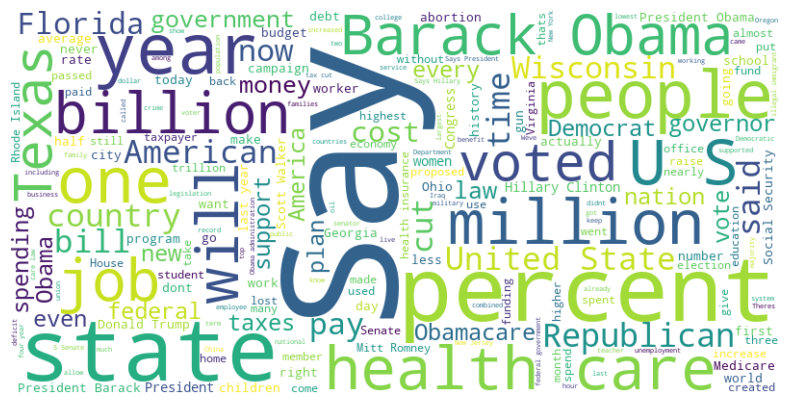

In [10]:
def generate_word_cloud(texts):
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


generate_word_cloud(train_data['Statement'])

In [11]:
def remove_stopwords(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [12]:
def clean_text_for_visualization(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.translate(str.maketrans('', '', "“”‘’—"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [13]:
def clean_df(dataframe):
    df_copy = dataframe.copy()
    df_copy['Statement'] = df_copy['Statement'].apply(remove_stopwords)
    df_copy['Statement'] = df_copy['Statement'].apply(clean_text_for_visualization)
    return df_copy

In [14]:
def plot_top_words(data, n=10):
    counter = Counter(" ".join(data).split())
    most_common = counter.most_common(n)
    most_common_words = [word for word, freq in most_common]
    frequencies = [freq for word, freq in most_common]
    plt.figure(figsize=(15, 5))
    sns.barplot(x=most_common_words, y=frequencies)
    plt.title('Top 10 most common words')
    plt.show()

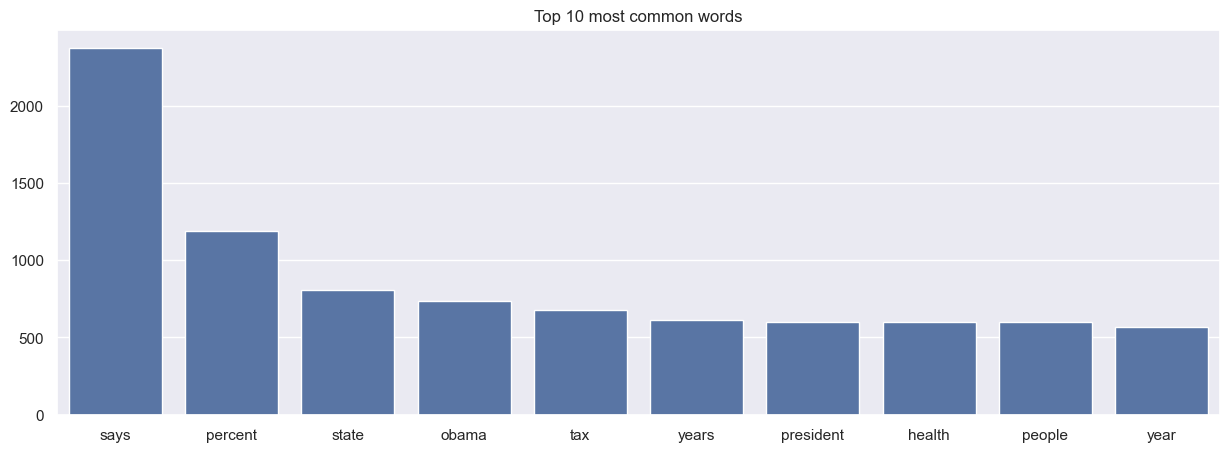

In [15]:
clean_train_data = clean_df(train_data)
plot_top_words(clean_train_data['Statement'])

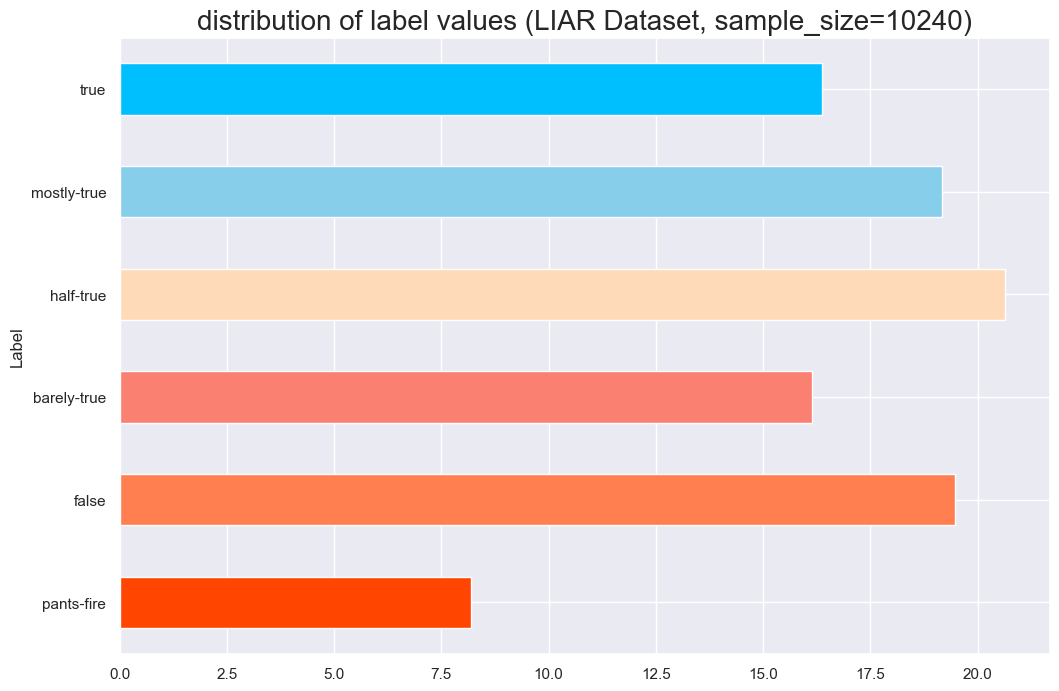

In [16]:
def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['Label'].value_counts(normalize=True)

    def multiply_100(x):
        return x * 100

    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)

    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered',  # pants-fire
        'coral',  # false
        'salmon',  # barely-true
        'peachpuff',  # half-true
        'skyblue',  # mostly-true
        'deepskyblue'  # true
    ]

    label_frequencies = label_frequencies.reindex(index=labels)

    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"distribution of label values ({title}, sample_size={len(input_df)})", size=20)


label_bar_chart(train_data)

In [17]:
num_unique_speakers = train_data['Speaker'].nunique()
avg_statments = len(train_data) / num_unique_speakers

print(f"Unique speakers in train dataset: {num_unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in train dataset: 2910
Average statements made per speaker: 3.5189003436426116


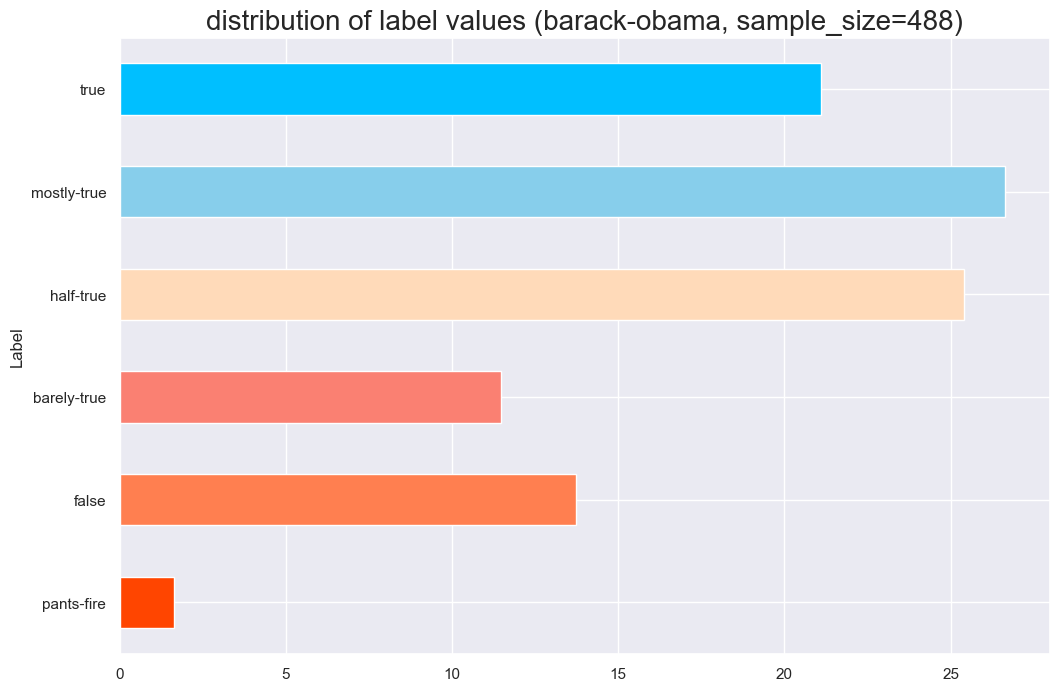

In [18]:
def speaker_bar_chart(input_df: pd.DataFrame, speaker: str) -> pd.DataFrame:
    # filters the input_df
    speaker_df = input_df[input_df['Speaker'] == speaker]
    speaker_df.reset_index(inplace=True)

    # calls the bar chart function we created earlier
    label_bar_chart(speaker_df, title=speaker)

    return speaker_df


ret_df = speaker_bar_chart(train_data, 'barack-obama')

In [19]:
def speaker_with_most_label(dataframe, label):
    # Filter the DataFrame based on the label
    label_df = dataframe[dataframe['Label'] == label]
    # Count the occurrences of each speaker for the label
    speaker_counts = label_df['Speaker'].value_counts()
    # Get the speaker with the most occurrences
    top_speaker = speaker_counts.idxmax()
    return top_speaker

In [20]:
top_speaker = speaker_with_most_label(train_df, 'false')
print(f"The speaker with the most 'false' labels is: {top_speaker}")

The speaker with the most 'false' labels is: donald-trump


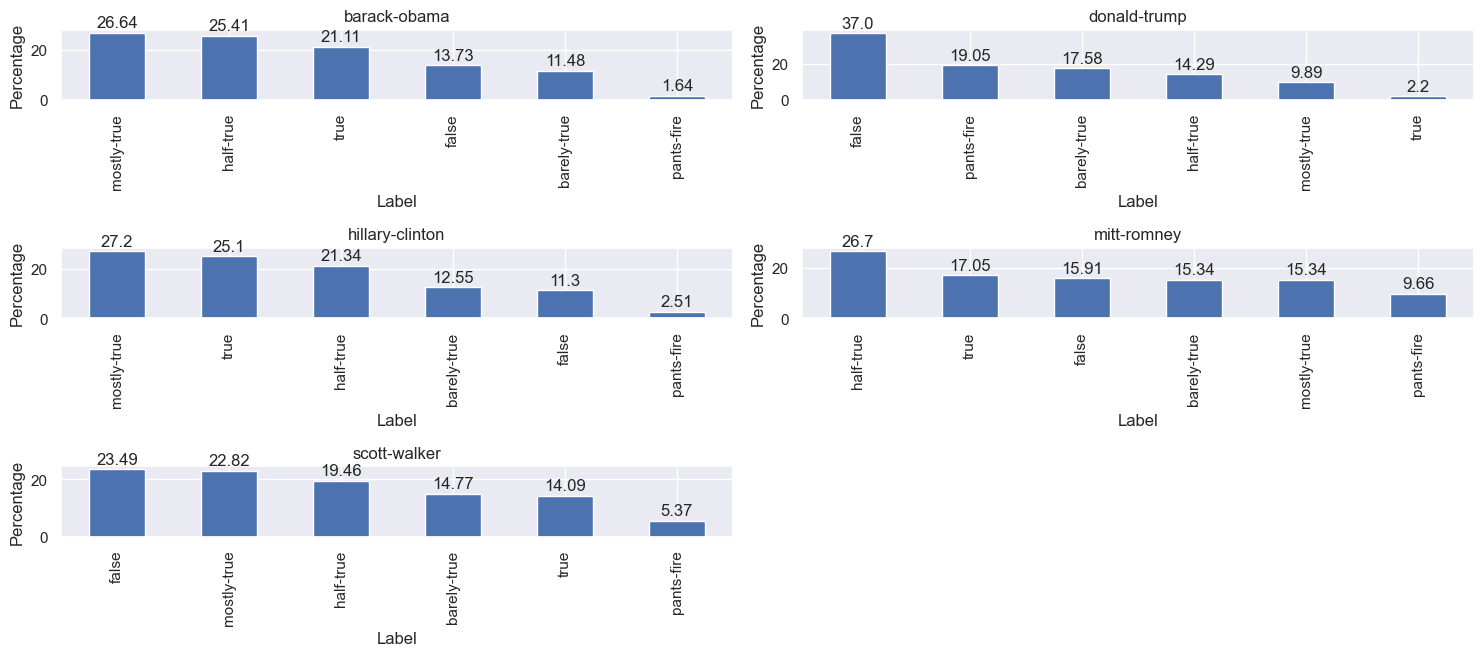

In [21]:

def plot_top_speakers_label_percentages(dataframe, n: int = 5):
    # Find the top 10 speakers
    top_speakers = dataframe['Speaker'].value_counts().index[:n]

    # Initialize a figure
    plt.figure(figsize=(15, 10))
    for i, speaker in enumerate(top_speakers):
        speaker_df = dataframe[dataframe['Speaker'] == speaker]
        label_counts = speaker_df['Label'].value_counts()
        label_percentages = (label_counts / label_counts.sum()) * 100
        ax = plt.subplot(5, 2, i + 1)
        bars = label_percentages.plot(kind='bar')
        plt.title(speaker)
        plt.xlabel('Label')
        plt.ylabel('Percentage')

        # Add percentage on each bar
        for bar in bars.patches:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()


plot_top_speakers_label_percentages(train_data)

In [22]:
def plot_annotated_ngrams_fixed(texts, labels, n=2, n_terms=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    feature_names = vec.get_feature_names_out()
    sum_words = bag_of_words.sum(axis=0)

    # Calculate the counts for each class
    class_counts = np.zeros((6, len(feature_names)))
    for label, row in zip(labels, bag_of_words):
        class_counts[label] += row.toarray()[0]

    # Aggregate total counts for each n-gram and sort them
    total_counts = sum_words.A1
    indices = np.argsort(-total_counts)
    top_indices = indices[:n_terms]

    # Prepare the data for plotting
    top_ngrams = feature_names[top_indices]
    top_counts = total_counts[top_indices]
    top_class_counts = [class_counts[i, top_indices] for i in range(6)]

    data = {
        'ngram': top_ngrams,
        'frequency': top_counts,
    }
    for i, class_name in enumerate(['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']):
        data[class_name] = top_class_counts[i]

    dataframe = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = sns.barplot(x='frequency', y='ngram', hue='ngram', data=dataframe, palette='viridis', legend=False)
    plt.title(f'Top {n}-grams in Dataset')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')

    # Annotate bars with the count of each class
    for i, bar in enumerate(bars.patches):
        annotation = ', '.join(f'{class_name}: {int(dataframe.iloc[i][class_name])}' for class_name in
                               ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true'])
        plt.text(
            bar.get_width(),
            bar.get_y() + bar.get_height() / 2,
            annotation,
            va='center'
        )

    plt.show()

In [23]:
label2id = {'barely-true': 0, 'false': 1, 'half-true': 2, 'mostly-true': 3, 'pants-fire': 4, 'true': 5}
id2label = {v: k for k, v in label2id.items()}

In [24]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder and transform the labels
train_data_copy = train_data.copy()
train_data_copy['Label'] = le.fit_transform(train_data_copy['Label'])

# Print the transformed labels
train_data_copy.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,Justification
0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,2,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


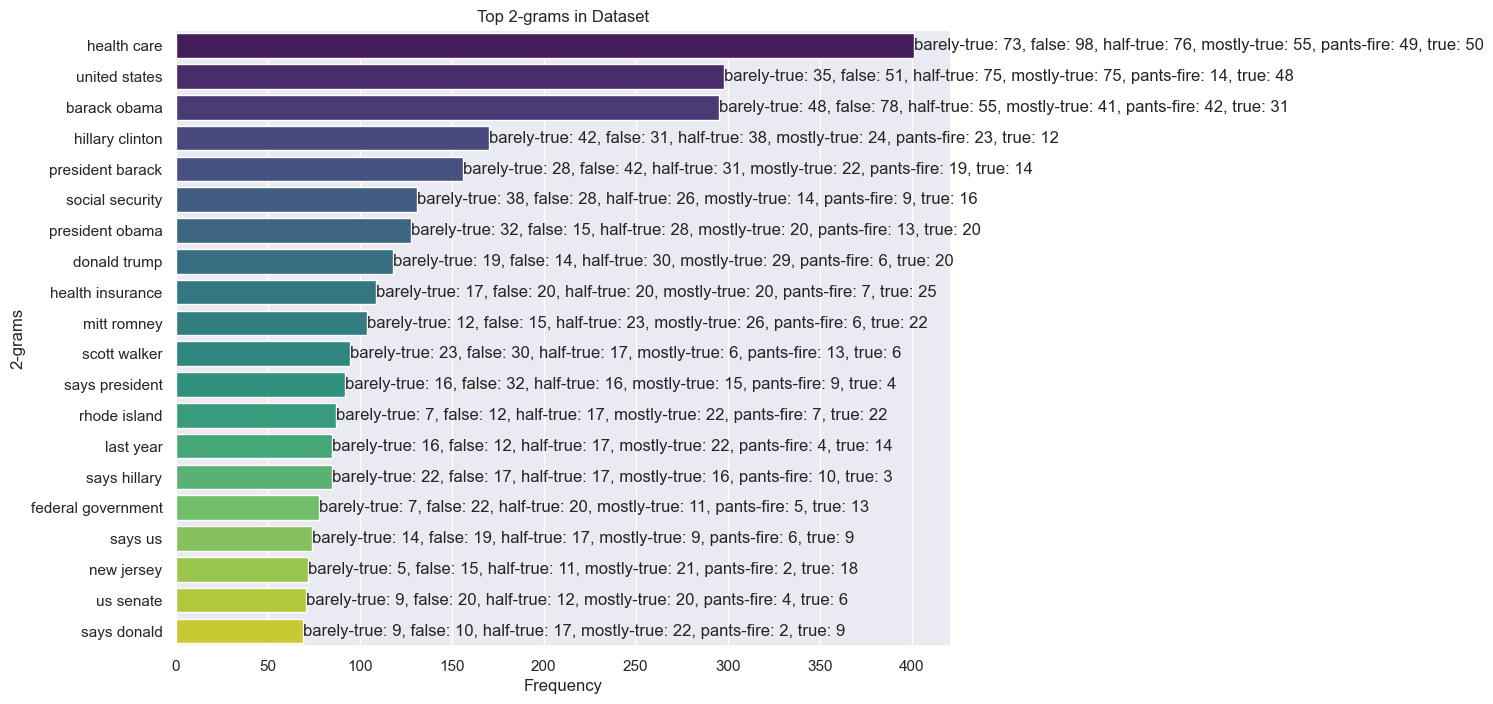

In [25]:
plot_annotated_ngrams_fixed(clean_train_data["Statement"], train_data_copy["Label"], n=2, n_terms=20)

In [26]:
os.environ["WANDB_PROJECT"] = "fake_news_classification"
os.environ["WANDB_LOG_MODEL"] = "true"
os.environ["WANDB_WATCH"] = "false"

In [27]:
from torch.utils.data import Dataset
import torch


class LiarLiarDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [40]:
from torch.utils.data import Dataset
import torch


class LiarLiarDataset2(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Statement']
        label = label2id[row['Label']]
        additional_text_features = [row['Subject'], row['Speaker'], row['Speaker Job Title'], row['State Info'], row['Party Affiliation'], row['Context']]
        additional_text_features = ' '.join([str(feature) for feature in additional_text_features])
        additional_numeric_features = [str(row['Barely True Counts']), str(row['False Counts']), str(row['Half True Counts']), str(row['Mostly True Counts']), str(row['Pants on Fire Counts'])]
        additional_numeric_features = ' '.join(additional_numeric_features)
        text = text + ' ' + additional_text_features + ' ' + additional_numeric_features
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def create_sliced_dataset(dataset, percentage=1):
    num_instances = int(len(dataset) * percentage)
    sliced_df = dataset[:num_instances]
    print(sliced_df['Label'].value_counts())
    return LiarLiarDataset2(sliced_df, tokenizer)

In [42]:
from transformers import RobertaTokenizerFast
import random
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
train_dataset = create_sliced_dataset(train_data)
val_dataset = create_sliced_dataset(val_data)
test_dataset = create_sliced_dataset(test_data)

Label
half-true      216
false          210
mostly-true    200
true           167
barely-true    149
pants-fire      82
Name: count, dtype: int64
Label
false          263
mostly-true    251
half-true      248
barely-true    237
true           169
pants-fire     116
Name: count, dtype: int64
Label
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: count, dtype: int64


In [43]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


def compute_metrics(eval_pred):
    eval_predictions, eval_labels = eval_pred
    eval_predictions = np.argmax(eval_predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_predictions, average='weighted',zero_division=0)
    acc = accuracy_score(eval_labels, eval_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [44]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, \
    DataCollatorWithPadding, RobertaTokenizerFast

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6, id2label=id2label,
                                                         label2id=label2id)
training_args = TrainingArguments(
    output_dir='./results',
    report_to=["wandb"],
    num_train_epochs=5,
    per_device_train_batch_size=32,
    warmup_steps=500,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
history = trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
results = trainer.evaluate(test_dataset)
print(results)

In [162]:
wandb.finish()